In [7]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview         as tpv
import shapefile         as shp
import numpy             as np
import xarray            as xr
import time              as clock
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'dmoc'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')

vname     = 'amoc'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2
which_dpi = 300
do_contour= True
which_transf = 'dmoc'
do_zcoord = False
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]


In [10]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path is not None) and (ref_path is not "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False    

#______________________________________________________________________________________________________            
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]


/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE, ck=0.1
/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide


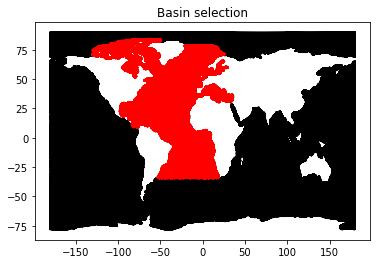

 --> create latitudinal bins
 --> do latitudinal bining
 --> do cumsum over latitudes
 --> do cumsum over depth (bottom-->top)
 --> normalize to northern boundary


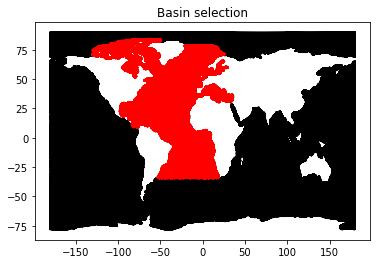

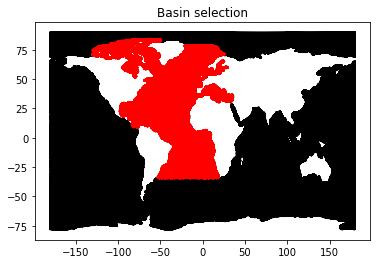

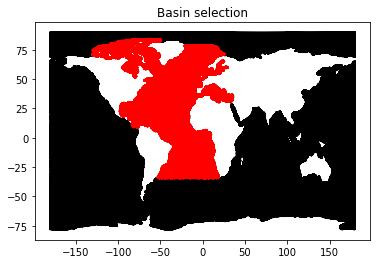

 --> elapsed time: 1.5166152079900106 min.


In [11]:
t1 = clock.time()
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if (ref_path is not None) and (ref_path is not "None"): 
    print(ref_path, ref_name)
    data_DMOC_ref = tpv.load_dmoc_data(mesh, ref_path, ref_name, year, which_transf, std_dens, do_info=False) #, n_area, e_area)

#___LOAD FESOM2 DATA___________________________________________________________________________________    
data_DMOC_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data_DMOC_list.append( tpv.load_dmoc_data(mesh, datapath, descript, year, which_transf, std_dens, do_info=False) ) # , n_area, e_area) )
    
#___COMPUTE XMOC_______________________________________________________________________________________
dmoc_list = list()
if (ref_path is not None) and (ref_path is not "None"): 
    dmoc_ref = tpv.calc_dmoc(mesh, data_DMOC_ref, dlat=1.0, which_moc=vname, do_checkbasin=True)
    if do_reffig: dmoc_list.append(dmoc_ref) 

for data in data_DMOC_list:
    dmoc     = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_checkbasin=True)
    if (ref_path is not None) and (ref_path is not "None"):  dmoc_list.append( tpv.do_anomaly(dmoc, dmoc_ref) )
    else:                                                    dmoc_list.append( dmoc )
print(' --> elapsed time: {} min.'.format( (clock.time()-t1)/60))

--> histo: cmin, cmax =  -4.531812461243371 16.793766474481306
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cref': 0.0, 'cmin': -4.53, 'cmax': 16.79, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f90936f0e90>, 'clevel': array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.])}
--> histo: cmin, cmax =  -1.6260920833313892 1.1454245156198914
--> histo: cmin, cmax =  -2.241371665414182 1.692182043597425
--> histo: cmin, cmax =  -2.241371665414182 1.7201741543345208
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0.0, 'chist': True, 'ctresh': 0.995, 'cmin': -2.24, 'cmax': 1.72, 'cmap': <matplotlib.colors.ListedColormap object at 0x7f8ffe9a5a50>, 'clevel': array([-2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3,
       -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,
       -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
        1. ,  1.1,  1.2, 

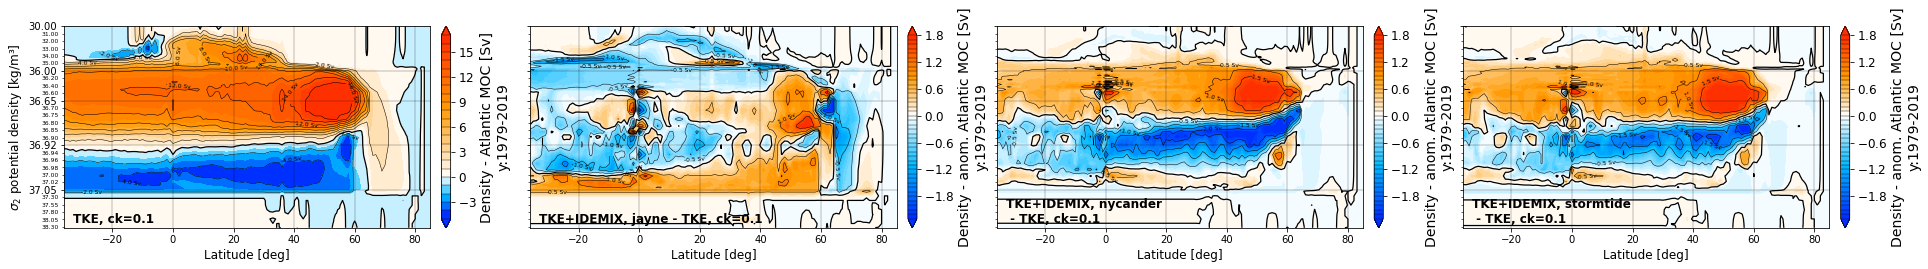

In [13]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = dmoc_list[0]['dmoc'].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncolumn= np.min([ncolumn,len(dmoc_list)])    
nrow   = np.ceil(len(dmoc_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname

#____________________________________________________________________________________________________
fig, ax, cbar=tpv.plot_dmoc(dmoc_list, which_moc=vname, which_transf=which_transf, 
                            cinfo=cinfo, do_reffig=do_reffig, ref_cinfo=ref_cinfo, 
                            figsize=[ncolumn*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncolumn], 
                            do_save=spath, save_dpi=which_dpi, do_contour=do_contour, do_yrescale=True, do_zcoord=do_zcoord) #do_zcoord)

# fig, ax, cbar=tpv.plot_dmoc([dmoc_list[0]], which_moc=vname, which_transf=which_transf, cinfo=cinfo, figsize=[ncolumn*7, nrow*3.5], n_rc=[nrow, ncolumn], 
#               do_save = spath, save_dpi=which_dpi, do_contour = do_contour, do_yrescale=True, do_zcoord=True) #do_zcoord)